In [27]:
import sys
import os
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

%load_ext autoreload
%autoreload 2
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Data from Folders


In [28]:
from io import StringIO


data: dict[str, dict[str, dict[str, pd.DataFrame]]] = {}

directories = []
for root, dirs, files in os.walk("../../../../data/benchmark-cluster/suitability-tuning-exploding"):
    for name in dirs:
        directories.append(os.path.join(root, name))

count = 0
for directory in directories:
    files = os.listdir(directory)

    for file in files:
        # skip folders
        if ".csv" not in file:
            continue

        file_type = file.split("_")[1]

        tuning_algorithm = directory.split("/")[-1]
        rank = directory.split("/")[-2]
        thread = directory.split("/")[-3]
        scenario = directory.split("/")[-4]

        with open(os.path.join(directory, file)) as f:
            content = f.read()
            print(directory, file)
            df_tuners = pd.read_csv(StringIO(content))

        if not scenario in data:
            data[scenario] = {}

        if not thread in data[scenario]:
            data[scenario][thread] = {}

        if not rank in data[scenario][thread]:
            data[scenario][thread][rank] = {}

        if not tuning_algorithm in data[scenario][thread][rank]:
            data[scenario][thread][rank][tuning_algorithm] = {}

        print(f"Adding {file} to {scenario} {
              thread} {rank} {tuning_algorithm}")

        data[scenario][thread][rank][tuning_algorithm][file_type] = df_tuners
        count += 1

print(f"Added {count} files")

../../../../data/benchmark-cluster/suitability-tuning-exploding/1/0.70 AutoPas_iterationPerformance_Rank0_2024-07-20_15-55-22.csv
Adding AutoPas_iterationPerformance_Rank0_2024-07-20_15-55-22.csv to benchmark-cluster suitability-tuning-exploding 1 0.70
../../../../data/benchmark-cluster/suitability-tuning-exploding/1/0.70 AutoPas_tuningData_Rank0_2024-07-20_15-55-22.csv
Adding AutoPas_tuningData_Rank0_2024-07-20_15-55-22.csv to benchmark-cluster suitability-tuning-exploding 1 0.70
../../../../data/benchmark-cluster/suitability-tuning-exploding/1/0.70 AutoPas_tuningResults_Rank0_2024-07-20_15-55-22.csv
Adding AutoPas_tuningResults_Rank0_2024-07-20_15-55-22.csv to benchmark-cluster suitability-tuning-exploding 1 0.70
../../../../data/benchmark-cluster/suitability-tuning-exploding/1/0.60 AutoPas_tuningData_Rank0_2024-07-20_16-04-19.csv
Adding AutoPas_tuningData_Rank0_2024-07-20_16-04-19.csv to benchmark-cluster suitability-tuning-exploding 1 0.60
../../../../data/benchmark-cluster/suitabi

# Make Line Plot of Smoothed Value over Iterations


2.6042485341221564
2.2351222219815012
1.5425105219565034
1.4356516386967755
1.464452846596117
1.4838957404382966
1.4860892951420714
1.4571108580951588
1.5014625992000665
1.5337991963169735
1.5569421766519458
1.9098528560953254
1.9279443312223985
1.9738640339971667


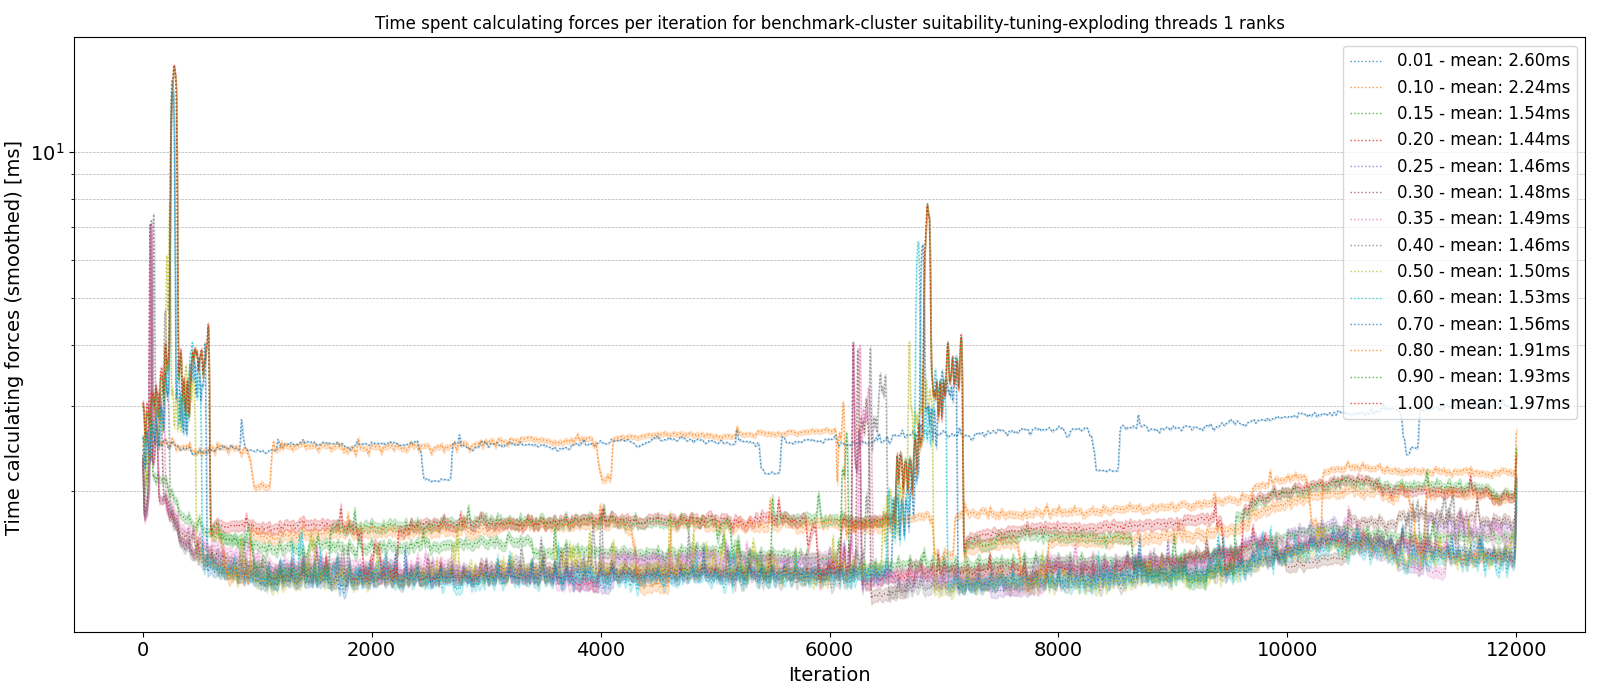

In [29]:
from scipy.signal import lfilter
from tsmoothie.smoother import *

for scenario, s_data in data.items():

    for threads, t_data in s_data.items():

        for rank, r_data in t_data.items():

            fig, ax = plt.subplots(1, 1, figsize=(16, 7))

            min_y=np.inf
            max_y=-np.inf
            # sort by mean time spent calculating forces
            for tuning_algorithm, logs in sorted(r_data.items(), key=lambda x: x[1]["iterationPerformance"][x[1]["iterationPerformance"]["inTuningPhase"] == True]["iteratePairwiseTotal[ns]"].sum(), reverse=False):

                iteration_data = logs["iterationPerformance"]

                time_s = iteration_data["iteratePairwiseTotal[ns]"] / 1e9

                first_k = 40000

                x = iteration_data["Iteration"][:first_k]
                y = time_s[:first_k] * 1000

                min_y = min(min_y, y.min())
                max_y = max(max_y, y.max())
                mean = y.mean()

                print(mean)

                if np.logical_or(np.isnan(y), np.isinf(y)).any():
                    raise ValueError(f"Found NaN or Inf in {
                        tuning_algorithm + threads + scenario}")

                smoother = ConvolutionSmoother(
                    window_len=40, window_type='blackman')
                smoother.smooth(y)
                low, up = smoother.get_intervals(
                    'sigma_interval', n_sigma=0.02)

                linewidth = 2.5 if "Fuzzy" in tuning_algorithm else 1
                opacity = 1 if "Fuzzy" in tuning_algorithm else 0.8
                linestyle = "-" if "Fuzzy" in tuning_algorithm else ":"

                color = ax._get_lines.get_next_color()
                if "Suitability" in tuning_algorithm:
                    color = "orangered"
                elif "Components" in tuning_algorithm:
                    color = "royalblue"

                ax.plot(x, smoother.smooth_data[0], label=f"{
                        tuning_algorithm} - mean: {mean:.2f}ms", linewidth=linewidth, alpha=opacity, linestyle=linestyle, color=color)

                ax.fill_between(x, low[0], up[0], alpha=0.2, color=color)

            ax.legend(prop={'size': 12})
            ax.set_xlabel("Iteration")
            ax.set_ylabel(
                "Time calculating forces (smoothed) [ms] ")

            # set y axis to mikro seconds

            ax.set_title(f"Time spent calculating forces per iteration for {
                scenario} {threads} threads {rank} ranks")
            # ax.set_xlim(0, df["Iteration"].max())
            # log

            # make y axis bigger
            ax.yaxis.set_tick_params(labelsize=14)
            ax.xaxis.set_tick_params(labelsize=14)
            # make axis title bigger
            ax.yaxis.label.set_size(14)
            ax.xaxis.label.set_size(14)

            fig.tight_layout()

            #grid and subgrid
            ax.grid("on", which="both", ls="--", linewidth=0.5,axis="y")

            # logarithmic scale
            ax.set_yscale('log')

            fig.savefig(
                f"SpinodalDecompositionMPI_timings_{scenario}_{threads}_{rank}.png", dpi=300)

# Make bar plots about total time

/tmp/ipykernel_113057/3772571557.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(18, 8))


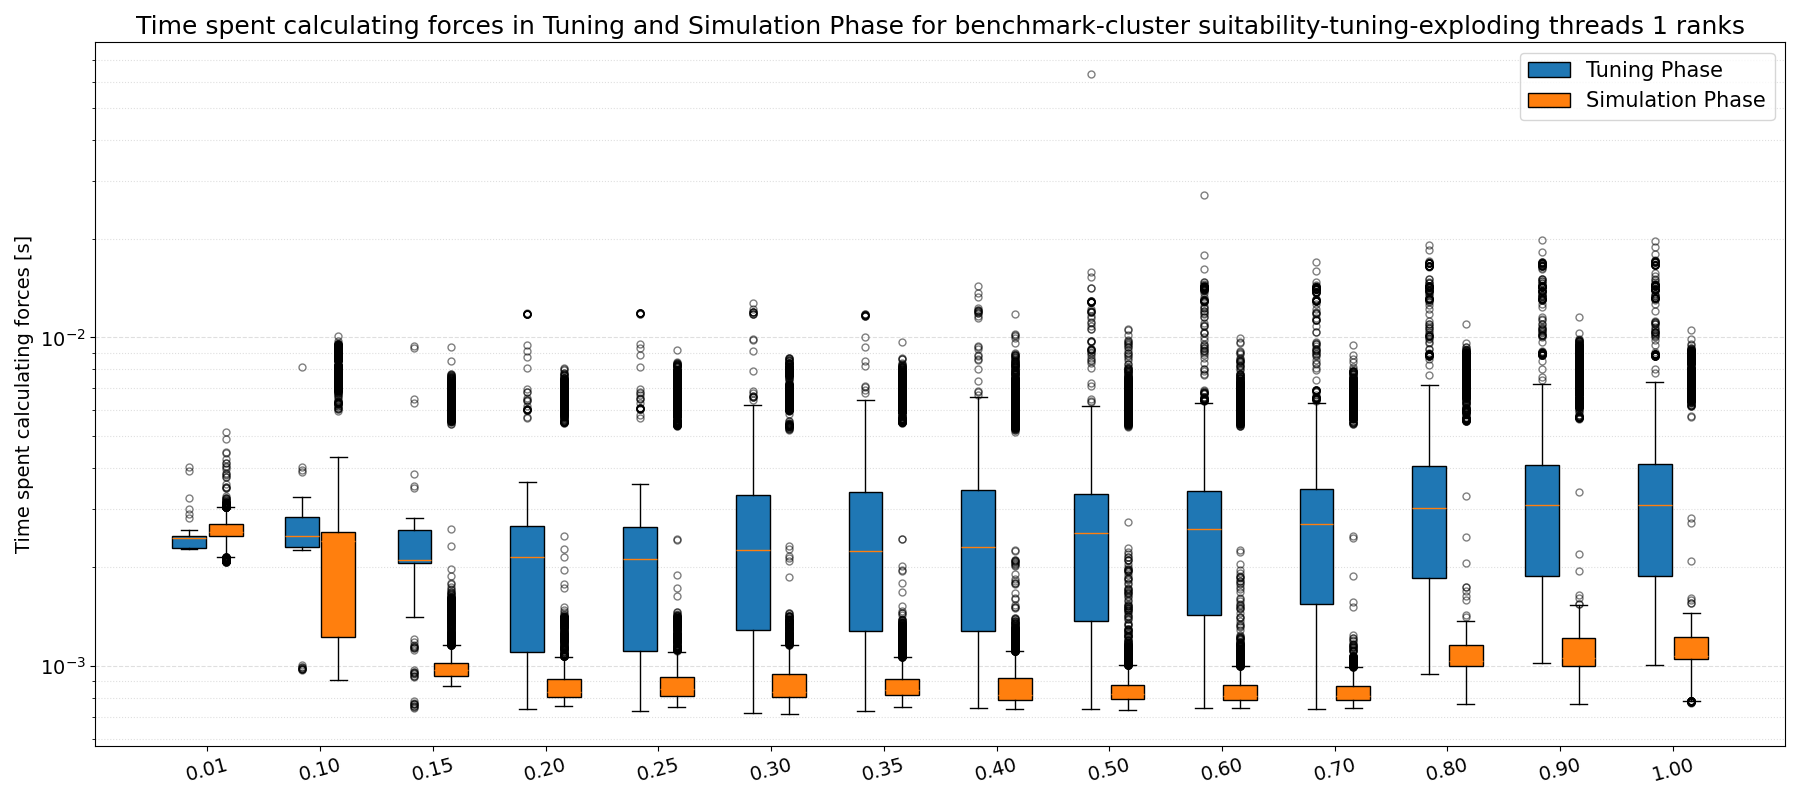

In [30]:
for scenario, s_data in data.items():
    for threads, t_data in sorted(s_data.items(), key=lambda x: x[0]):

        for rank, r_data in t_data.items():

            timings = {}
            algorithms = []

            # Collect data
            for tuning_algorithm, logs in sorted(r_data.items(), key=lambda x: x[1]["iterationPerformance"][x[1]["iterationPerformance"]["inTuningPhase"] == True]["iteratePairwiseTotal[ns]"].sum(), reverse=False):
                algorithms.append(tuning_algorithm)
                iteration_data = logs["iterationPerformance"]
                tuning_iterations = iteration_data[iteration_data["inTuningPhase"] == True]
                simulation_iterations = iteration_data[iteration_data["inTuningPhase"] == False]

                timings[tuning_algorithm] = {
                    "Tuning Phases": tuning_iterations["iteratePairwiseTotal[ns]"] / 1e9,
                    "Simulation Phases": simulation_iterations["iteratePairwiseTotal[ns]"] / 1e9
                }
            # Create plot
            fig, ax = plt.subplots(figsize=(18, 8))

            # Set positions for boxplots
            # Increased spacing between algorithm groups
            positions = range(0, len(algorithms) * 4, 4)
            width = 1.2  # Increased width of boxes

            # Function to add jittered points
            def add_jittered_points(data, pos, color, alpha=0.2):
                y = data
                x = np.random.normal(pos, 0.1, size=len(y))
                ax.scatter(x, y, alpha=alpha, s=10, color=color, zorder=3)
            # Create boxplots with jittered outliers
            bp_tuning = ax.boxplot([timings[alg]["Tuning Phases"] for alg in algorithms],
                                   positions=[p - width/2 -
                                              0.05 for p in positions],
                                   widths=width, patch_artist=True, flierprops=dict(marker='o', markersize=5, alpha=0.5))

            bp_simulation = ax.boxplot([timings[alg]["Simulation Phases"] for alg in algorithms],
                                       positions=[p + width/2 +
                                                  0.05 for p in positions],
                                       widths=width, patch_artist=True, flierprops=dict(marker='o', markersize=5, alpha=0.5))

            # Add scatter plots
            # for i, alg in enumerate(algorithms):
            #     add_jittered_points(
            #         timings[alg]["Tuning Phases"], positions[i] - width/2, '#3498db')
            #     add_jittered_points(
            #         timings[alg]["Simulation Phases"], positions[i] + width/2, '#e67e22')

            # Increase font sizes
            plt.title(
                f'Time spent calculating forces in Tuning and Simulation Phase for {scenario} {threads} threads {rank} ranks', fontsize=18)
            ax.set_ylabel('Time spent calculating forces [s]', fontsize=16)

            # Rotate x-axis labels
            plt.xticks(rotation=15, fontsize=14)
            plt.yticks(fontsize=14)

            # Use more distinct colors
            for box in bp_tuning['boxes']:
                box.set(facecolor='#1f77b4')
            for box in bp_simulation['boxes']:
                box.set(facecolor='#ff7f0e')  # Orange

            ax.set_xticks(positions)
            ax.set_xticklabels(algorithms, rotation=15)

            # minor grid lines on y
            ax.yaxis.grid(True, linestyle=':', which='minor',
                          color='grey', alpha=.25)

            # Add legend
            ax.legend([bp_tuning["boxes"][0], bp_simulation["boxes"][0]],
                      ["Tuning Phase", "Simulation Phase"], fontsize=15)

            # Logarithmic y-axis
            ax.set_yscale('log')

            # more grid lines
            ax.yaxis.grid(True, linestyle='--', which='major',
                          color='grey', alpha=.25)

            ax.yaxis.set_tick_params(labelsize=14)
            ax.xaxis.set_tick_params(labelsize=14)
            # make axis title bigger
            ax.yaxis.label.set_size(14)

            fig.tight_layout()

            fig.savefig(f"SpinodalDecompositionMPI_timings_boxplot_{
                        scenario}_{threads}_{rank}.png", dpi=300)

            plt.show()

0.01
0.1
0.15
0.2
0.25
0.3
0.35
0.4
0.5
0.6
0.7
0.8
0.9
1.0


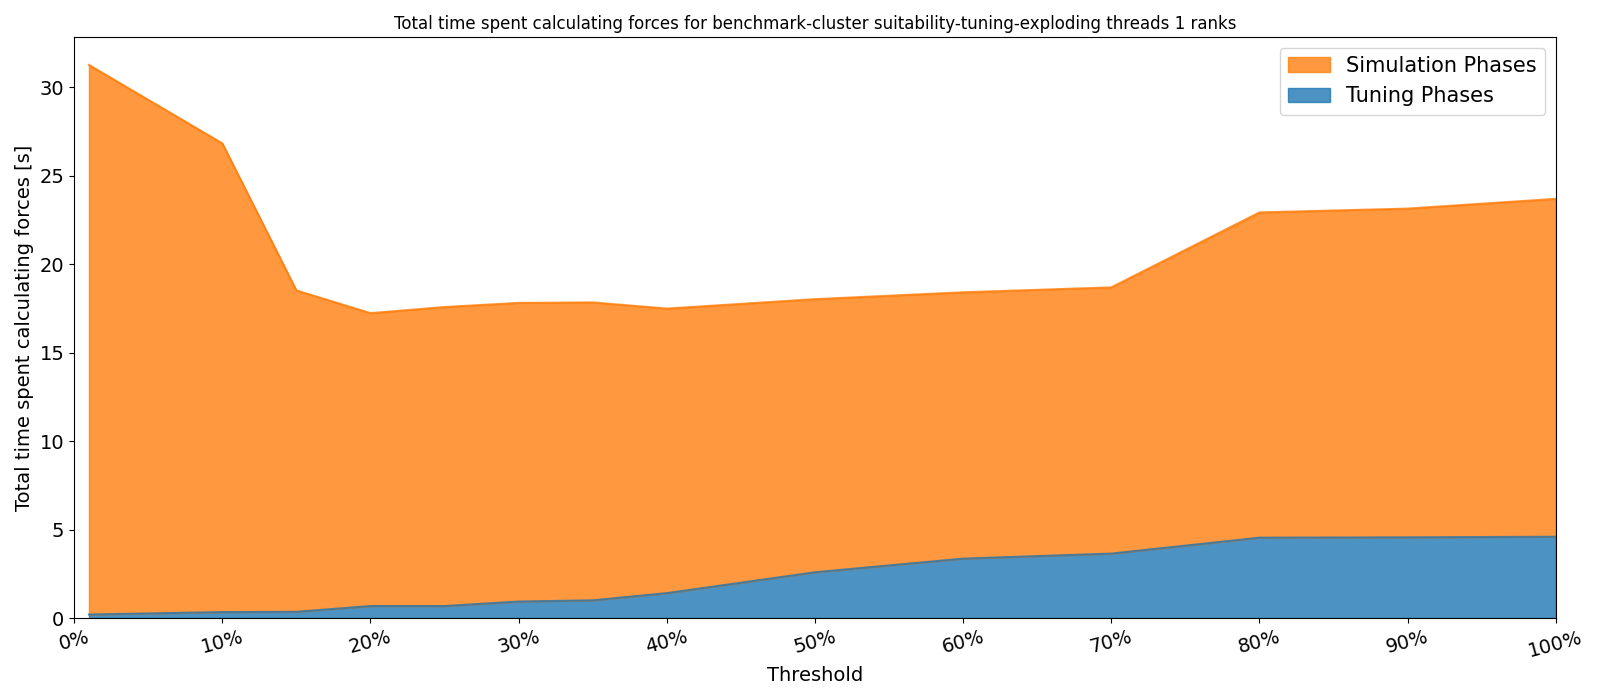

In [35]:
for scenario, s_data in data.items():
    for threads, t_data in sorted(s_data.items(), key=lambda x: x[0]):

        for rank, r_data in t_data.items():

            timings = {}
            algorithms = []

            # Collect data
            for tuning_algorithm, logs in sorted(r_data.items(), key=lambda x: x[0], reverse=False):
                algorithms.append(tuning_algorithm)
                iteration_data = logs["iterationPerformance"]
                tuning_iterations = iteration_data[iteration_data["inTuningPhase"] == True]
                simulation_iterations = iteration_data[iteration_data["inTuningPhase"] == False]

                try:
                    threshold = float(tuning_algorithm.split("_")[0])
                    print(threshold)
                except:
                    threshold = 1.05

                timings[threshold] = {
                    "Tuning Phases": tuning_iterations["iteratePairwiseTotal[ns]"].sum() / 1e9,
                    "Simulation Phases": simulation_iterations["iteratePairwiseTotal[ns]"].sum() / 1e9,
                    "Total": iteration_data["iteratePairwiseTotal[ns]"].sum() / 1e9
                }

            # df with tuning algorithm as row
            df = pd.DataFrame(timings).T

            fig, ax = plt.subplots(1, 1, figsize=(16, 7))

            # fill below lines
            df.drop(["Total"], axis=1).plot(kind="area", ax=ax, alpha=0.8,stacked=True)

            # tilt x labels
            plt.xticks(rotation=15, fontsize=16)

            # every 5 percent
            ax.set_xticks(np.arange(0, 1.1, 0.1))

            # format x labels as percentage
            ax.xaxis.set_major_formatter(plt.FuncFormatter(
                lambda x, _: f"{x:.0%}"))
            ax.set_xlabel("Threshold")

            # xrange
            ax.set_xlim(0, 1)

            ax.set_ylabel(
                "Total time spent calculating forces [s]", fontsize=16)

            ax.set_title(f"Total time spent calculating forces for {
                scenario} {threads} threads {rank} ranks")

            handles, lables = ax.get_legend_handles_labels()
            ax.legend(handles[::-1], lables[::-1], prop={'size': 15})

            # make y axis bigger
            ax.yaxis.set_tick_params(labelsize=14)
            ax.xaxis.set_tick_params(labelsize=14)
            # make axis title bigger
            ax.yaxis.label.set_size(14)
            ax.xaxis.label.set_size(14)

            fig.tight_layout()

            # logarithmic scale

            fig.savefig(f"SuitabilityExploding_timings_threshold_{
                        scenario}_{threads}_{rank}.png", dpi=300)

In [32]:
# Function to add jittered points
def add_jittered_points(data, pos, color, alpha=0.2, vert=True, highlight=None):
    y = data
    x = np.random.normal(pos, 0.1, size=len(y))

    highlight = highlight if highlight is not None else np.zeros(
        len(y), dtype=bool)

    if vert:
        plt.scatter(x, y, color=color, alpha=alpha)

        # plot highlighted points
        plt.scatter(x[highlight], y[highlight], color="red", alpha=alpha)

    else:
        plt.scatter(y, x, color=color, alpha=alpha)

        # plot highlighted points
        plt.scatter(y[highlight], x[highlight], color="red", alpha=alpha)

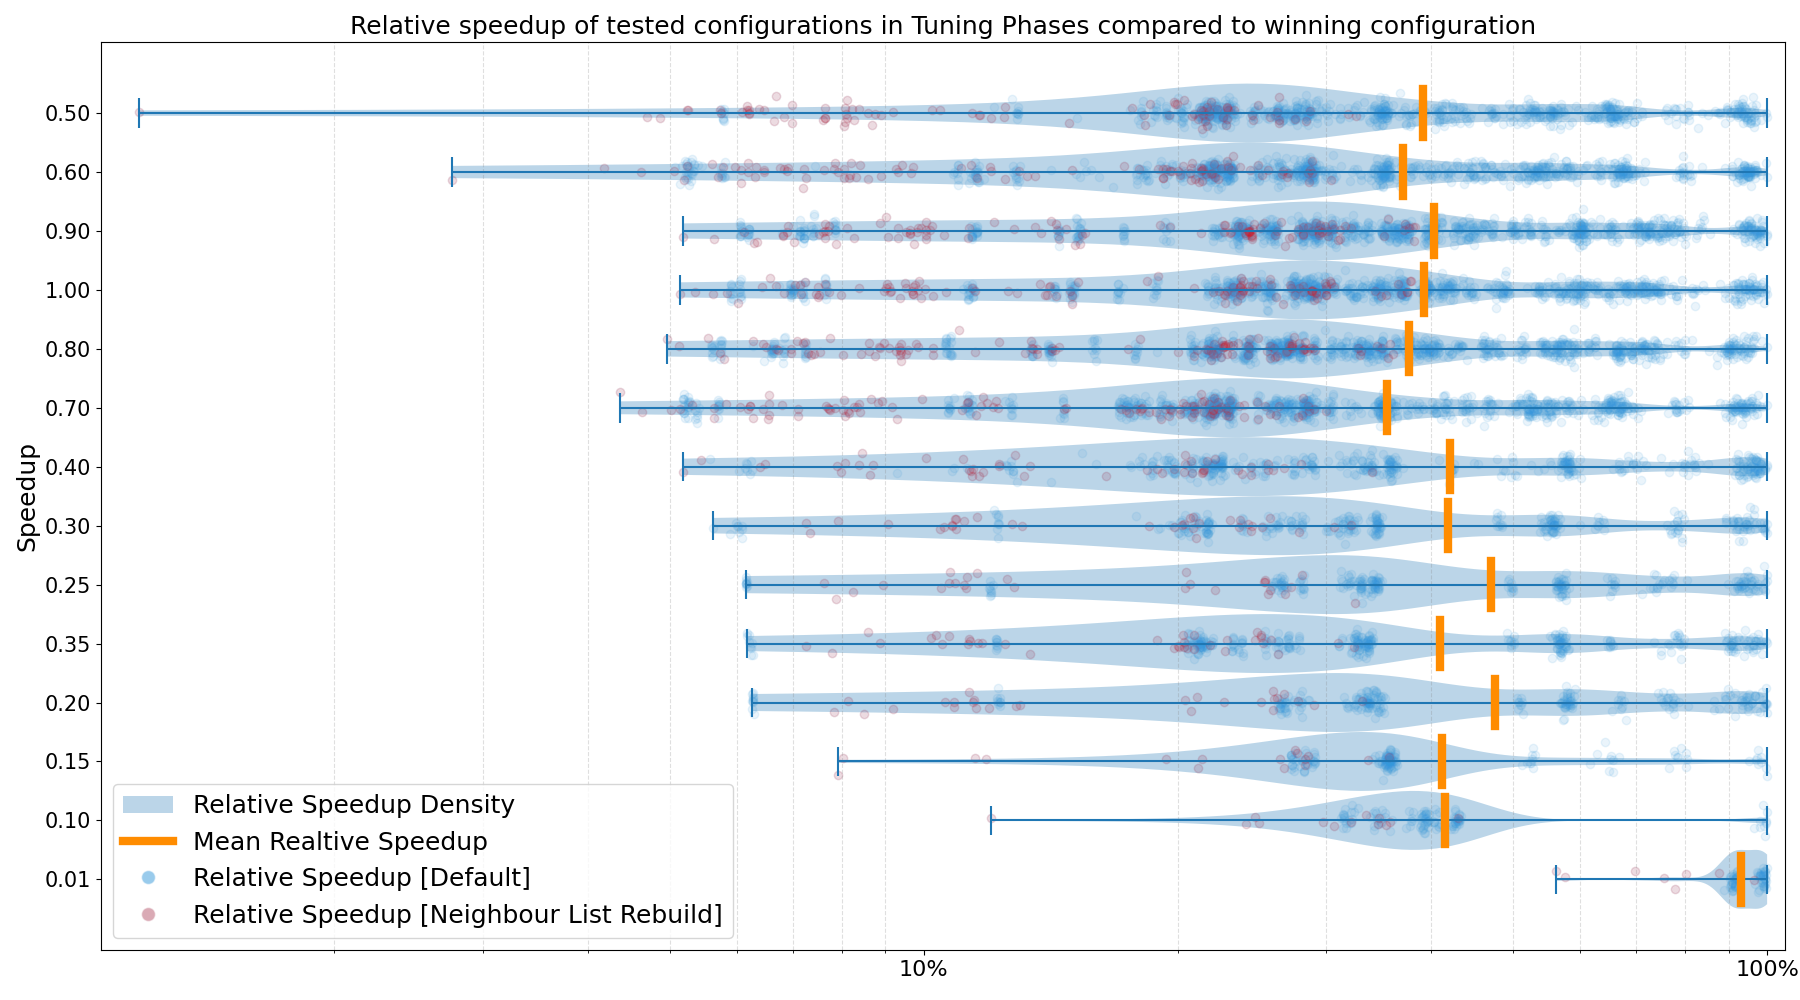

In [33]:
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import pandas as pd
import numpy as np


for scenario, s_data in data.items():
    for threads, t_data in sorted(s_data.items(), key=lambda x: x[0]):

        for rank, r_data in t_data.items():
            min_speedup = 1
            speedups = {}
            algorithms = []

            def calc_speedup(x): return x.min() / x

            # Collect data, sort by lowest speedup for tuning phase
            for tuning_algorithm, logs in sorted(r_data.items(), key=lambda x: calc_speedup(x[1]["iterationPerformance"]["iteratePairwiseTotal[ns]"]).min(), reverse=True):
                algorithms.append(tuning_algorithm)
                iteration_data = logs["iterationPerformance"]
                tuning_iterations = iteration_data[iteration_data["inTuningPhase"] == True]

                speedups[tuning_algorithm] = {
                    "Speedup": calc_speedup(tuning_iterations["iteratePairwiseTotal[ns]"]),
                    "Verlet Rebuilds": tuning_iterations["rebuildNeighborLists[ns]"],
                }

                min_speedup = min(
                    min_speedup, speedups[tuning_algorithm]["Speedup"].min())

            fig, ax = plt.subplots(figsize=(18, 10))

            positions = range(0, len(algorithms))
            width = 1  # Increased width of boxes

            bp_tuning = ax.violinplot([speedups[alg]["Speedup"]
                                       for alg in algorithms],
                                      positions=[p for p in positions],
                                      widths=width, vert=False)

            for i, alg in enumerate(algorithms):
                add_jittered_points(
                    speedups[alg]["Speedup"], positions[i], '#3498db', vert=False, alpha=0.1, highlight=speedups[alg]["Verlet Rebuilds"] > 0)

            # add median lines
            for i, alg in enumerate(algorithms):
                mean = speedups[alg]["Speedup"].mean()
                ax.plot([mean, mean], [positions[i] - 0.4, positions[i] + 0.4],
                        color='darkorange', linewidth=6)

            # Increase font sizes
            plt.title(
                'Relative speedup of tested configurations in Tuning Phases compared to winning configuration', fontsize=18)
            ax.set_ylabel('Speedup', fontsize=16)

            # Rotate x-axis labels

            # Use more distinct colors
            for box in bp_tuning['bodies']:
                box.set(facecolor='#1f77b4')

            ax.set_yticks(positions)

            ax.set_yticklabels(algorithms)

            # minor grid lines on y
            ax.yaxis.grid(True, linestyle=':', which='minor',
                          color='grey', alpha=.25)

            # Add legend
            ax.legend([bp_tuning["bodies"][0], Line2D([0], [0], color='darkorange', lw=6), Line2D([0], [0], marker='o', color='w', markerfacecolor='#3498db', markersize=10, alpha=0.5), Line2D([0], [0], marker='o', color='w', markerfacecolor='#b6566c', markersize=10, alpha=0.5)],

                      ["Relative Speedup Density", "Mean Realtive Speedup", "Relative Speedup [Default]", "Relative Speedup [Neighbour List Rebuild]"], fontsize=18)

            # Logarithmic y-axis
            ax.set_xscale('log')

            # more grid lines
            ax.xaxis.grid(True, linestyle='--', which='minor',
                          color='grey', alpha=.25)

            ax.yaxis.set_tick_params(labelsize=15)
            ax.xaxis.set_tick_params(labelsize=16)
            # make axis title bigger

            ax.yaxis.label.set_size(18)

            fig.tight_layout()

            # limit x axis to 1
            ax.set_xlim(min_speedup*0.9, 1.05)

            # y label percent
            ax.xaxis.set_major_formatter(PercentFormatter(xmax=1))

            fig.savefig(f"tuning_phase_speedup_{scenario}_{
                        threads}_{rank}.png", dpi=300)